# Step-wise engine for indicators

This notebook showcases the usage of the `Engine` class allowing a step-wise iteration over indicator generation.

It has two main steps:

1. Initialisation with the starting variable state at LSOA level
2. Change of a single variable in a single LSOA and generation of indicators.

We need to import the class and (here) use pandas to specify the initial state.

In [1]:
from demoland_engine import Engine, get_lsoa_baseline

<string>:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).


We have to specify the initial state. The state reflecting the current situation as closely as it could is stored in the `data/lsoa_baseline.parquet` file.

The bounds of allowed values per column:

    signature_type : int
        Int representing signature type. See below the possible options
        and their relationship to the signature type.

            0: 'Wild countryside',
            1: 'Countryside agriculture',
            2: 'Urban buffer',
            3: 'Warehouse/Park land',
            4: 'Open sprawl',
            5: 'Disconnected suburbia',
            6: 'Accessible suburbia',
            7: 'Connected residential neighbourhoods',
            8: 'Dense residential neighbourhoods',
            9: 'Gridded residential quarters',
            10: 'Dense urban neighbourhoods',
            11: 'Local urbanity',
            12: 'Regional urbanity',
            13: 'Metropolitan urbanity',
            14: 'Concentrated urbanity',
            15: 'Hyper concentrated urbanity',

    use : float, optional
        Float in a range -1...1 reflecting the land use balance between
        fully residential (-1) and fully commercial (1). Defautls to 0,
        a value derived from signatures. For values < 0, we are allocating
        workplace population to residential population. For values > 0, we
        are allocating residential population to workplace population.
        Extremes are allowed but are not realistic, in most cases.
    greenspace : float, optional
        Float in a range 0...1 reflecting the amount of greenspace in the
        area. 0 representes no accessible greenspace, 1 represents whole
        area covered by a greenspace. This value will proportionally affect
        the amounts of jobs and population.
    job_types : float, optional
        Float in a range 0...1 reflecting the balance of job types in the
        area between entirely blue collar jobs (0) and entirely white collar
        jobs (1).

In [2]:
lsoa_input = get_lsoa_baseline()
lsoa_input.head()

,signature_type,use,greenspace,job_types
E01008162,8,0,0,0.531270
E01008163,10,0,0,0.834764
E01008164,8,0,0,0.520837
E01008165,8,0,0,0.583986
E01008166,10,0,0,0.592752


Initialise the class. This will take a few seconds due to sampling of all underlying OA-level values but all of them are cached for subsequent steps.

In [3]:
eng = Engine(lsoa_input, random_seed=1)

At every step, you can retrieve the array with indicators using `Engine.indicators`. We can use it to save the values for the baseline just to check if they will have changed.

In [4]:
base = eng.indicators.copy()

This is the key part. At the moment, it expects a location of a change within a 2D array and a new value at that location. The class will transfer that to the OA level, adapts/samples values of affected OAs and generates new indicators based on those values.

In [5]:
%%time
eng.change((100, 2), 0.9)

CPU times: user 655 ms, sys: 389 ms, total: 1.04 s
Wall time: 929 ms


This takes about 600ms on a M1 MacBook Air per change.

See the signature for details.

In [6]:
help(eng.change)

Help on method change in module demoland_engine.engine:

change(iloc, val) method of demoland_engine.engine.Engine instance
    Change a single variable on a single area and recompute indicators
    
    Parameters
    ----------
    iloc : tuple (row, col)
        tuple reflecitng the position of a change suitable for positional indexing
    val : float
        new value of a specified position



You can now check the change.

In [7]:
(base - eng.indicators).sum()

air_quality                 3.599572e+00
house_price                 1.023145e+00
job_accessibility           0.000000e+00
greenspace_accessibility   -5.234117e+06
dtype: float64

The `Engine.indicators` attribute returns a pandas.DataFrame like this.

In [8]:
eng.indicators

,air_quality,house_price,job_accessibility,greenspace_accessibility
lsoa,,,,
E01008162,17.634044,7.560321,6254.500000,4.198600e+05
E01008163,17.565636,7.365526,9306.500000,5.007069e+05
E01008164,17.093546,7.368993,2445.800000,4.657973e+05
E01008165,17.291046,7.391033,3271.200000,3.457522e+05
E01008166,17.659567,7.504862,16046.000000,1.733233e+05
...,...,...,...,...
E01033550,15.152310,8.138539,332.666667,6.965745e+04
E01033551,14.847872,8.042019,767.333333,6.739372e+04
E01033553,19.287248,7.496966,37975.666667,1.292969e+05


<AxesSubplot: ylabel='Frequency'>

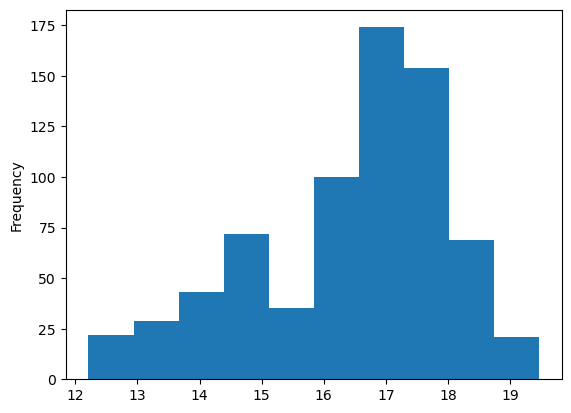

In [9]:
eng.indicators.air_quality.plot.hist()

<AxesSubplot: ylabel='Frequency'>

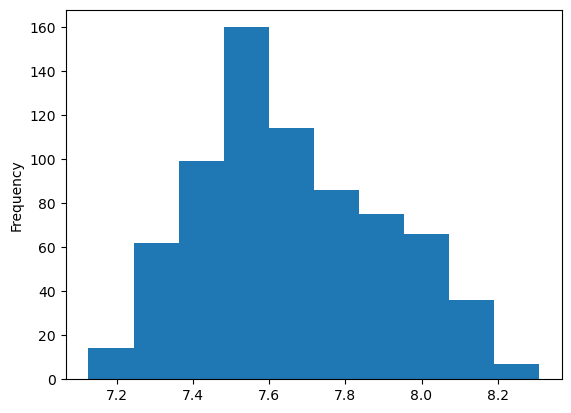

In [10]:
eng.indicators.house_price.plot.hist()

<AxesSubplot: ylabel='Frequency'>

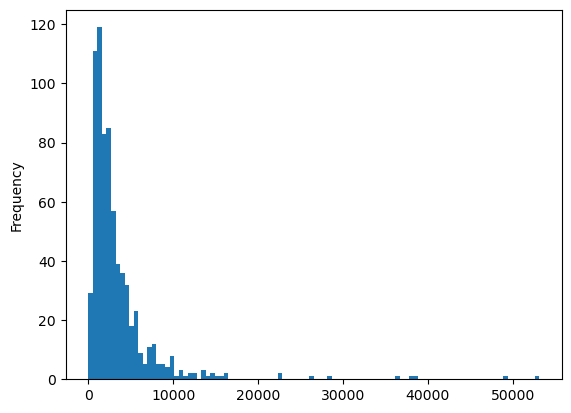

In [11]:
eng.indicators.job_accessibility.plot.hist(bins=100)

<AxesSubplot: ylabel='Frequency'>

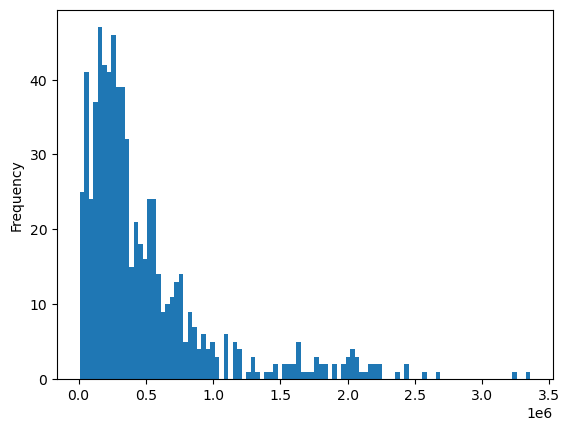

In [12]:
eng.indicators.greenspace_accessibility.plot.hist(bins=100)